# Creating a scoring function

When exploring the competitive-matches dataset, we found something interesting:

    >>> competitive.groupby(['p1', 'p2', 'p3', 'p4', 'p5']).apply(len).value_counts()
    1    14045  
    2      519  
    3       43  
    4        7  
    dtype: int64  

As we can see from above, theres only 7 team compositions that were played 4 times in competitive matches. That forms less than 0.05% of the number of unique team compositions played in competitions. 96.1% of the team compositions seen **were played only once**. That makes sense if you think about there being 464,306,843 (143C5) different ways to compose a team as of early 2019. 

## Why do we need to come up with a scoring function?

    >>> competitive.groupby(['p1', 'p2', 'p3', 'p4', 'p5'])['win'].apply(np.mean).value_counts()
    0.000000    7170
    1.000000    7130
    0.500000     280
    0.333333      19
    0.666667      14
    0.250000       1
    Name: win, dtype: int64

From above, it is obvious that mean is not a good scoring function for our dataset. There are 569 unique combinations in total that were played more than once. Out of those, at least 314 of them were penalised by the mean function as they had a loss in one of the matches. This means that the mean function views 2/3 wins worse than 1/1 wins which is absolutely undesirable (2-1 should be better than 1-0). Hence, we have to come up with a new scoring function that can bring justice to such scenarios. Furthermore, we would also like a function that outputs a negative number for more likely to lose which mean cannot do as it is always positive for this dataset.

    Option A: goodpickscore(n_wins, n) = win_rate(n_wins, n) + bias(n)
    Option B: goodpickscore(n_wins, n) = win_rate(n_wins, n) * bias(n)

Our bias function may change depending on whether we choose + or \*. Our bias function basically determines whether the team composition is more "reliable", that is, whether it has been played for a few times rather than only once.

### Tests

Test 1: goodpickscore(2,3) > goodpickscore(1,1)  
Test 2: goodpickscore(7,12) < goodpickscore(4,6)  


### Win rate
Let us first define our win_rate function:
\begin{equation*}
winrate(n_{wins}, n) = \frac{n_{wins} - n_{loss}}{n} = \frac{n_{wins} - (n - n_{wins})}{n} = \frac{2n_{wins} - n }{n} = \frac{2n_{wins}}{n} - 1
\end{equation*}

This function has a range of -1 to 1.

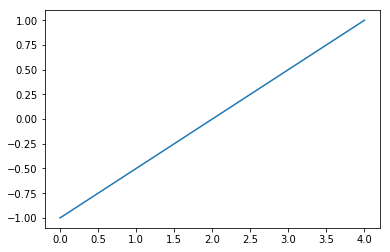

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def win_rate(n_wins, n):
    return 2*(n_wins/n) - 1

X = np.arange(5)
plt.plot(X, [win_rate(x, 4) for x in X])
# 4 matches, 5 outcomes:
# 0W4L (0.0, -1.00),
# 1W3L (1.0, -0.50),
# 2W2L (2.0,  0.00),
# 3W1L (3.0,  0.50),
# 4W0L (4.0,  1.00)

### Option A

    goodpickscore(n_wins, n) = win_rate(n_wins, n) + bias(n)

Let's try sigmoidal function for bias as they range from -1 to 1. This means it cannot overpower the win_rate (by that much). In this case we shall use tanh.

In [2]:
win_rate(1,1)

1.0

In [3]:
win_rate(2,3)

0.33333333333333326

In [4]:
win_rate(7,12)

0.16666666666666674

In [5]:
win_rate(1,1) + np.tanh(1)

1.7615941559557649

In [6]:
# tanh did not give 2-1 an edge over 1-0.
win_rate(2,3) + np.tanh(3)

1.3283880870200637

In [7]:
# Although win_rate is the same as the previous, tanh gave n=6 a slight edge over n=3.
win_rate(4,6) + np.tanh(6)

1.3333210449841288

In [8]:
# tanh does not overcompensate if the winrate was lower
win_rate(7,12) + np.tanh(12)

1.166666666591164

In [9]:
# how about tanh(0.5x)?
win_rate(1,1) + np.tanh(0.5*1)

1.4621171572600098

In [10]:
# Looks like tanh(0.5x) still can't help 2-1 be favoured over 1-0.
win_rate(2,3) + np.tanh(0.5*3)

1.2384815869781995

In [11]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

win_rate(1,1) + sigmoid(1)

1.7310585786300048

In [12]:
win_rate(2,3) + sigmoid(3)

1.2859074601557667

In [13]:
# What about losses?
win_rate(0,1)

-1.0

In [14]:
win_rate(5,12)

-0.16666666666666663

In [15]:
win_rate(5,12) - np.tanh(12)

-1.1666666665911638

##### Natural logarithm

In [16]:
win_rate(1,1) + np.log(1)

1.0

In [17]:
win_rate(2,3) + np.log(3)

1.431945622001443

In [18]:
win_rate(4,6) + np.log(6)

2.1250928025613884

In [19]:
# Overshadows lower winrate, not what we want
win_rate(7,12) + np.log(12)

2.651573316454667

##### Square root

In [20]:
win_rate(1,1) + np.sqrt(1)

2.0

In [21]:
win_rate(2,3) + np.sqrt(3)

2.0653841409022107

In [22]:
win_rate(4,6) + np.sqrt(6)

2.782823076116511

In [23]:
win_rate(7,12) + np.sqrt(12)

3.6307682818044213

##### Conclusion

\begin{equation*}
goodpickscore(n_{wins}, n) = winrate(n_{wins}, n) + \frac{winrate(n_{wins}, n)}{\mid winrate(n_{wins}, n) \mid} * bias(n)
\end{equation*}

Unfortunately, it is not adequate in helping the algorithm to favour 2-1 over 1-0.  

### Option B

    Option B: goodpickscore(n_wins, n) = win_rate(n_wins, n) * bias(n)

Let the logistic sigmoid function be our bias function.

In [24]:
win_rate(1,1) * sigmoid(1)

0.7310585786300049

In [25]:
# Doesn't pass test 1
win_rate(2,3) * sigmoid(3)

0.31752470894081103

##### Natural logarithm

In [26]:
# It is undesirable to reduce 1-matches to 0.0
win_rate(1,1) * np.log(1)

0.0

In [27]:
# Therefore, lets increase it to np.log(x + p)
win_rate(1,1) * np.log(1 + 0.3)

0.26236426446749106

In [28]:
win_rate(1,2) * np.log(2 + 0.3)

0.0

In [29]:
win_rate(2,2) * np.log(2 + 0.3)

0.8329091229351039

In [30]:
win_rate(2,3) * np.log(3 + 0.3)

0.3979741561574781

In [31]:
win_rate(3,3) * np.log(3 + 0.3)

1.1939224684724346

In [32]:
win_rate(4,6) * np.log(6 + 0.3)

0.6135165444658288

In [33]:
# Jackpot!
win_rate(7,12) * np.log(12 + 0.3)

0.4182665437297289

##### Conclusion

We should use
\begin{equation*}
goodpickscore(n_{wins}, n) = winrate(n_{wins}, n) * ln(n + p), 0 \lt p \leq 0.5
\end{equation*}

However, the draw back is that when win = lose, the result is 0. The first approach does better in this case as it will encourage the algorithm to favour 'seen' compositions over unseen ones, while this approach does not give them this benefit.

In [34]:
# Try to find 

def goodpickscore(n_wins, n, p):
    return win_rate(n_wins, n) * np.log(n + p)

X = np.linspace(0,1,11)
X

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

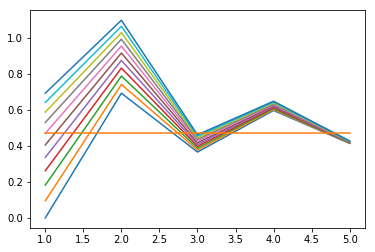

In [35]:
for x in X:
    plt.plot([1,2,3,4,5], [goodpickscore(1,1,x), goodpickscore(2,2,x), goodpickscore(2,3,x), goodpickscore(4,6,x), goodpickscore(7,12,x)])

# Anything above this orange line should not be considered.
plt.plot([1,2,3,4,5], [0.47,0.47,0.47,0.47,0.47])

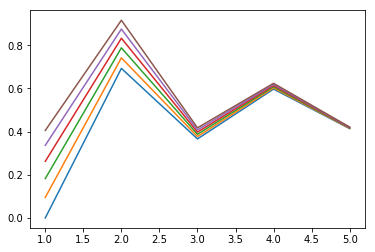

In [36]:
# Try to find a good p for our goodpickscore
X = np.linspace(0,0.5,6)

for x in X:
    plt.plot([1,2,3,4,5], [goodpickscore(1,1,x), goodpickscore(2,2,x), goodpickscore(2,3,x), goodpickscore(4,6,x), goodpickscore(7,12,x)])


Since a team that has been played once and won is more reliable than a team that has never been played before, we cannot allow p = 0 as that would penalise this.

However, we would like the algorithm to favour compositions that are played more often, and therefore, p = 0.2 and 0.3 are good for this as the gap between 1-0 and 2-1 is larger than for p=0.4 and p=0.5

\begin{equation*}
goodpickscore(n_{wins}, n) = winrate(n_{wins}, n) * ln(n + p), 0.2 \leq p \leq 0.3
\end{equation*}

## Option C

Since Option B has the draw back for win = lose cases, we need to improve Option B so that it still favours them over team compositions that have seen 0 plays.

As such, we propose

\begin{equation*}
goodpickscore(n_{wins}, n) = winrate(n_{wins}, n) * ln(n + p) + s * bias(n), p = 0.2
\end{equation*}

\begin{equation*}
s = -1, winrate(n_{wins}, n) < 0
\end{equation*}

\begin{equation*}
s = 1, winrate(n_{wins}, n) \geq 0
\end{equation*}

Where we merged both Option A and B together

In [37]:
def goodpickscore(n_wins, n):
    p = 0.2
    w = win_rate(n_wins, n)
    s = np.sign(w)
    if s == 0:
        s = 1
    return w * np.log(n + p) + s * np.tanh(n)

print("Out of 1 matches")
print("0-1: %s"  % goodpickscore(0,1))
print("1-0:  %s" % goodpickscore(1,1))
print()
print("Out of 2 matches")
print("0-2: %s"  % goodpickscore(0,2))
print("1-1:  %s" % goodpickscore(1,2))
print("2-0:  %s" % goodpickscore(2,2))
print()
print("Out of 3 matches")
print("0-3: %s"  % goodpickscore(0,3))
print("1-2: %s"  % goodpickscore(1,3))
print("2-1:  %s" % goodpickscore(2,3))
print("3-0:  %s" % goodpickscore(3,3))
print()
print("Out of 4 matches")
print("0-4: %s"  % goodpickscore(0,4))
print("1-3: %s"  % goodpickscore(1,4))
print("2-2:  %s" % goodpickscore(2,4))
print("3-1:  %s" % goodpickscore(3,4))
print("4-0:  %s" % goodpickscore(4,4))
print()
print("Others")
print("4-2: %s" % goodpickscore(4,6))
print("7-5: %s" % goodpickscore(7,12))

Out of 1 matches
0-1: -0.9439157127497194
1-0:  0.9439157127497194

Out of 2 matches
0-2: -1.752484940440087
1-1:  0.9640275800758169
2-0:  1.752484940440087

Out of 3 matches
0-3: -2.1582055634924115
1-2: -1.382771690288624
2-1:  1.382771690288624
3-0:  2.1582055634924115

Out of 4 matches
0-4: -2.4344138250283898
1-3: -1.7168715623837283
2-2:  0.999329299739067
3-1:  1.7168715623837283
4-0:  2.4344138250283898

Others
4-2: 1.6081708090011442
7-5: 1.4169059918810327


In [38]:
scores = {
    "0-1": goodpickscore(0,1),
    "1-0": goodpickscore(1,1),
    
    "0-2": goodpickscore(0,2),
    "1-1": goodpickscore(1,2),
    "2-0": goodpickscore(2,2),
    
    "0-3": goodpickscore(0,3),
    "1-2": goodpickscore(1,3),
    "2-1": goodpickscore(2,3),
    "3-0": goodpickscore(3,3),
    
    "0-4": goodpickscore(0,4),
    "1-3": goodpickscore(1,4),
    "2-2": goodpickscore(2,4),
    "3-1": goodpickscore(3,4),
    "4-0": goodpickscore(4,4)
}

inv_map = {v: k for k, v in scores.items()}

["%s: %s" % (inv_map[i],i) for i in sorted(list(scores.values()))]  

['0-4: -2.4344138250283898',
 '0-3: -2.1582055634924115',
 '0-2: -1.752484940440087',
 '1-3: -1.7168715623837283',
 '1-2: -1.382771690288624',
 '0-1: -0.9439157127497194',
 '1-0: 0.9439157127497194',
 '1-1: 0.9640275800758169',
 '2-2: 0.999329299739067',
 '2-1: 1.382771690288624',
 '3-1: 1.7168715623837283',
 '2-0: 1.752484940440087',
 '3-0: 2.1582055634924115',
 '4-0: 2.4344138250283898']

Above is how our scoring function would rank the win-losses. It is pretty satisfactory except we feel that 3-1 is better than 2-0. However since they are pretty close together we decided not to change it further.

### What about a simpler approach

Win = +20
Lose = +5

This will favour more matches played which is one of the factors we are looking for. Teams that win more will always be above teams that lose more

However, it is bad for 2 reasons. 

1. No negative - Unable to tell which team comp is bad vs lack of plays.
2. Case of 20 wins in 20 matches vs 40 wins 60 losses in 100 matches. 

First scenario is obviously better than second scenario, and could be representative of a new meta team, but this approach favours more games way too much to be able to adapt.


In [40]:
print("20-0  | points:%s - goodpickscore:%s" % (20*20, goodpickscore(20,20)))
print("40-60 | points:%s - goodpickscore:%s" % (40*20+60*5, goodpickscore(40,60)))

20-0  | points:400 - goodpickscore:4.005682604407159
40-60 | points:1100 - goodpickscore:2.3658907841049253


### Limitations

LOL will always revisit and revamp champions from time to time. goodpickscore is also affected by historical data, it will take a long time for goodpickscore to catch up to the meta. Some scoring algorithms combat this by giving more weight to more recent matches. We may explore this when we have more data per team composition.


### Future Plans

There are many scoring systems that have been adopted by games, organisations and tournament alike. Instead of rolling our own scoring system, we might want to take a leaf out of how other organisations implement theirs. One notable point that other scoring systems account for that ours doesn't is that they take into account how strong the opponent is. However, due to our limited dataset, it is not realistic for us to assess the relative strength of each team composition. This is something that needs to be addressed as more and more data is made available.